#![](https://raw.githubusercontent.com/tg-bomze/BabyGAN/master/media/logo.png)

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository: [BabyGAN](https://github.com/tg-bomze/BabyGAN)**

*Creator: [Denis Malimonov](https://github.com/tg-bomze)*

---
<b><font color="black" size="+1">Used:</font></b>

Neural Network: **[StyleGAN](https://github.com/NVlabs/stylegan)** (*Creators: [Tero Karras](https://research.nvidia.com/person/tero-karras), [Samuli Laine](https://research.nvidia.com/person/samuli-laine), [Timo Aila](https://research.nvidia.com/person/timo-aila)*)

Encoder: **[stylegan-encoder](https://github.com/pbaylies/stylegan-encoder)** *(Creators: [Peter Baylies](https://github.com/pbaylies), [Dmitry Nikitko](https://github.com/Puzer))*

---


```
To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Clone Git repository and install all requirements</font></b>
%tensorflow_version 1.x

!pip install 'h5py<3.0.0'

import os
import cv2
import math
import pickle
import imageio
import warnings
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randrange
import moviepy.editor as mpy
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
%matplotlib inline
warnings.filterwarnings("ignore")

def get_watermarked(pil_image: Image) -> Image:
  try:
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    (h, w) = image.shape[:2]
    image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
    pct = 0.08
    full_watermark = cv2.imread('/content/BabyGAN/media/logo.png', cv2.IMREAD_UNCHANGED)
    (fwH, fwW) = full_watermark.shape[:2]
    wH = int(pct * h*2)
    wW = int((wH * fwW) / fwH*0.1)
    watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
    overlay = np.zeros((h, w, 4), dtype="uint8")
    (wH, wW) = watermark.shape[:2]
    overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
    output = image.copy()
    cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
    rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)
  except: return pil_image

def generate_final_images(latent_vector, direction, coeffs, i):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img_path = "/content/BabyGAN/for_animation/" + str(i) + ".png"
    img.thumbnail(animation_size, PIL.Image.ANTIALIAS)
    img.save(img_path)
    face_img.append(imageio.imread(img_path))
    clear_output()
    return img

def generate_final_image(latent_vector, direction, coeffs):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    img.save("face.png")
    if download_image == True: files.download("face.png")
    return img

def plot_three_images(imgB, fs = 10):
  f, axarr = plt.subplots(1,3, figsize=(fs,fs))
  axarr[0].imshow(Image.open('/content/BabyGAN/aligned_images/father_01.png'))
  axarr[0].title.set_text("Father's photo")
  axarr[1].imshow(imgB)
  axarr[1].title.set_text("Child's photo")
  axarr[2].imshow(Image.open('/content/BabyGAN/aligned_images/mother_01.png'))
  axarr[2].title.set_text("Mother's photo")
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

!rm -rf sample_data
!git clone https://github.com/tg-bomze/BabyGAN.git
%cd /content/BabyGAN
!mkdir aligned_images data father_image mother_image

import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

age_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/age.npy')
horizontal_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/angle_horizontal.npy')
vertical_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/angle_vertical.npy')
eyes_open_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/eyes_open.npy')
gender_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/gender.npy')
smile_direction = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/smile.npy')

clear_output()

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Save the weights of the pretrained model and mount Google Drive</font></b>
#@markdown **Follow this link:**

#@markdown **https://drive.google.com/drive/folders/1xwqqG0HkLe2AiXxjC-XK8OfvMKT1jBlp**

#@markdown **1) right click on 'BabyGAN' (top center)**

#@markdown **2) select 'Add shortcut to Drive**

#@markdown ![](https://raw.githubusercontent.com/tg-bomze/BabyGAN/master/media/mount_eng.png)

#@markdown **3) run this block and follow the further instructions**

#@markdown *Attention! If the weights have already been saved, then run this block and just mount Google Drive.*

print("Follow the link below, select the account where you saved the pretrained model,")
print("click the 'Allow' button, copy authorization code in the field below and press Enter.")
drive.mount('/content/drive')
clear_output()
if os.path.isdir('/content/drive/My Drive/BabyGAN'):
  print("0%/100%   Copying has started")
  !cp '/content/drive/My Drive/BabyGAN/finetuned_resnet.h5' '/content/BabyGAN/data'
  !cp '/content/drive/My Drive/BabyGAN/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5' '/content/BabyGAN'
  print("50%/100%  Checkpoints copied")
  !cp '/content/drive/My Drive/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl' '/content/BabyGAN'
  !cp '/content/drive/My Drive/BabyGAN/vgg16_zhang_perceptual.pkl' '/content/BabyGAN'
  print("90%/100%  Weights copied")
  !cp '/content/drive/My Drive/BabyGAN/shape_predictor_68_face_landmarks.dat.bz2' '/content/BabyGAN'
  print("100%/100% Dictionary copied")
  clear_output()
  print("Done!")
else: raise ValueError('Please read the instructions in the block description and follow all 3 points correctly!')

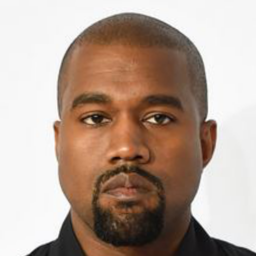

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload portrait of a MAN</font></b>

!rm -rf /content/BabyGAN/father_image/*.*
#@markdown *Enter a link to the image below or leave the **url** field blank (in this case, you will be asked to upload the photo from your computer).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1: raise ValueError('You cannot upload more than one image at a time!')
  fat = uploaded[0]
else:
  try:
    !wget $url
    fat = url.split('/')[-1]
  except BaseException:
    print("Something wrong. Try uploading a photo from your computer")

FATHER_FILENAME = "father." + fat.split(".")[-1]
os.rename(fat, FATHER_FILENAME)
father_path = "/content/BabyGAN/father_image/" + FATHER_FILENAME
!mv -f $FATHER_FILENAME $father_path

!python align_images.py /content/BabyGAN/father_image /content/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/content/BabyGAN/aligned_images/father_01.png'):
  pil_father = Image.open('/content/BabyGAN/aligned_images/father_01.png')
  (fat_width, fat_height) = pil_father.size
  resize_fat = max(fat_width, fat_height)/256
  display(pil_father.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
else: raise ValueError('No face was found or there is more than one in the photo.')

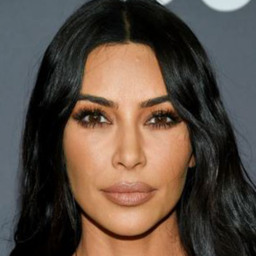

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload portrait of a WOMAN</font></b>

!rm -rf /content/BabyGAN/mother_image/*.*
#@markdown *Enter a link to the image below or leave the **url** field blank (in this case, you will be asked to upload the photo from your computer).*
url = '' #@param {type:"string"}
if url == '':
  uploaded = list(files.upload().keys())
  if len(uploaded) > 1: raise ValueError('You cannot upload more than one image at a time!')
  mot = uploaded[0]
else:
  try:
    !wget $url
    mot = url.split('/')[-1]
  except BaseException:
    print("Something wrong. Try uploading a photo from your computer")

MOTHER_FILENAME = "mother." + mot.split(".")[-1]
os.rename(mot, MOTHER_FILENAME)
mother_path = "/content/BabyGAN/mother_image/" + MOTHER_FILENAME
!mv -f $MOTHER_FILENAME $mother_path

!python align_images.py /content/BabyGAN/mother_image /content/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/content/BabyGAN/aligned_images/mother_01.png'):
  pil_mother = Image.open('/content/BabyGAN/aligned_images/mother_01.png')
  (mot_width, mot_height) = pil_mother.size
  resize_mot = max(mot_width, mot_height)/256
  display(pil_mother.resize((int(mot_width/resize_mot), int(mot_height/resize_mot))))
else: raise ValueError('No face was found or there is more than one in the photo.')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Get latent representation</font></b>
#@markdown *Attention! This process will take about 3 minutes.*

'''
#use_pretraineg_model = True #@param {type:"boolean"}
if use_pretraineg_model == False:
  !rm finetuned_resnet.h5
  !python train_resnet.py \
  --test_size 256 \
  --batch_size 1024 \
  --loop 1 \
  --max_patience 1'''

#!python encode_images.py --help
!python encode_images.py \
  --early_stopping False \
  --lr=0.25 \
  --batch_size=2 \
  --iterations=100 \
  --output_video=False \
  /content/BabyGAN/aligned_images \
  /content/BabyGAN/generated_images \
  /content/BabyGAN/latent_representations

tflib.init_tf()
URL_FFHQ = "/content/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)
model_scale = int(2*(math.log(1024,2)-1))

clear_output()
if len(os.listdir('/content/BabyGAN/generated_images')) == 2:
  first_face = np.load('/content/BabyGAN/latent_representations/father_01.npy')
  second_face = np.load('/content/BabyGAN/latent_representations/mother_01.npy')
  print("Generation of latent representation is complete! Now comes the fun part.")
else: raise ValueError('Something wrong. It may be impossible to read the face in the photos. Upload other photos and try again.')



---



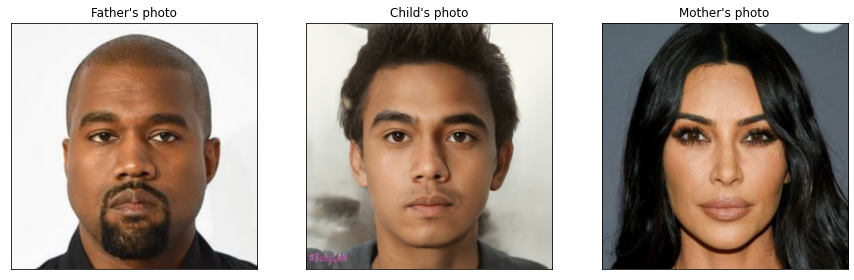

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating a child's face</font></b> { run: "auto", display-mode: "form" }
#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
genes_influence = 0.3 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **Styling a photo:**
style = "Default" #@param ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)
#@markdown **Child's approximate age:**
person_age = 10 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((person_age/5)-6)
#@markdown ---
#@markdown **Download the final image?**
download_image = False #@param {type:"boolean"}
#@markdown **Resolution of the downloaded image:**
resolution = "512" #@param [256, 512, 1024]
size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, age_direction, intensity)
plot_three_images(face, fs = 15)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of a smooth change of the child's GENDER</font></b> {display-mode: "form" }
!rm -rf /content/BabyGAN/for_animation
!mkdir /content/BabyGAN/for_animation
face_img = []

#@markdown **Child's approximate age:**
person_age = 10 #@param {type:"slider", min:10, max:50, step:1}
intensity = -((person_age/5)-6)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**

#@markdown *The higher value, the smoother the transition between frames.*
frames_number = 50 #@param {type:"slider", min:10, max:50, step:1}

for i in range(1, frames_number):
  gender_influence = i/frames_number
  hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
  face = generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
#@markdown *If the checkbox is not checked, the generated animation will be played under this block.*

animation_name = str(person_age) + "_years.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True: 
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of a smooth change of the child's AGE</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
gender_influence = 0.8 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**

#@markdown *The higher value, the smoother the transition between frames.*
frames_number = 50 #@param {type:"slider", min:10, max:50, step:1}
for i in range(0, frames_number, 1):
  intensity = (8*(i/(frames_number-1)))-4
  generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
#@markdown *If the checkbox is not checked, the generated animation will be played under this block.*

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Additional features** *(face modification)*

*____* *↓ Click to open section ↓* *____*

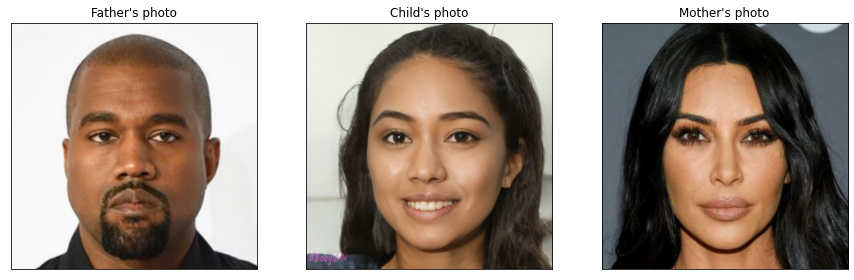

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Change the parameters of the child's face</font></b> { run: "auto", display-mode: "form" }
#@markdown **The genes of which parent will prevail and by how much:**

#@markdown *The closer to 0, the more influence the father's genotype will have. Closer to 1 - mother.*
genes_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
#@markdown **Styling a photo:**
style = "Default" #@param ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)

#@markdown **Option intensity:**
horizontal = -50 #@param {type:"slider", min:-100, max:100, step:1}
horizontal_intensity = horizontal/50
vertical = 0 #@param {type:"slider", min:-100, max:100, step:1}
vertical_intensity = vertical/50
eyes_open = 10 #@param {type:"slider", min:-100, max:100, step:1}
eyes_open_intensity = -(eyes_open/25)
gender = 0 #@param {type:"slider", min:-100, max:100, step:1}
gender_intensity = gender/100
smile = 100 #@param {type:"slider", min:-100, max:100, step:1}
smile_intensity = smile/100
age = -100 #@param {type:"slider", min:-100, max:100, step:1}
age_intensity = -(age/25)

direction_intensity = (horizontal_direction*horizontal_intensity) + (vertical_direction*vertical_intensity) + (eyes_open_direction*eyes_open_intensity) + (gender_direction*gender_intensity) + (smile_direction*smile_intensity) + (age_direction*age_intensity)

#@markdown ---
#@markdown **Download the final image?**
download_image = False #@param {type:"boolean"}
#@markdown **Resolution of the downloaded image:**
resolution = "512" #@param [256, 512, 1024]
size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, direction_intensity, 1)
plot_three_images(face, fs = 15)

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation for smooth change of the selected option</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**
gender_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
#@markdown **Animation resolution:**
animation_resolution = "512" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)

#@markdown **Number of frames:**
frames_number = 50 #@param {type:"slider", min:9, max:50, step:1}
#@markdown **Option for animation:**
for i in range(0, frames_number, 1):
  intensity = (100*(i/(frames_number-1)))-50
  
  horizontal_intensity = intensity/25
  vertical_intensity = intensity/25
  eyes_open_intensity = -(intensity/12.5)
  gender_intensity = intensity/50
  smile_intensity = intensity/50
  age_intensity = -(intensity/12.5)

  horizontal = horizontal_direction * horizontal_intensity
  vertical = vertical_direction * vertical_intensity
  eyes_open = eyes_open_direction * eyes_open_intensity
  gender = gender_direction * gender_intensity
  smile = smile_direction * smile_intensity
  age = age_direction * age_intensity

  dir_int = horizontal #@param ["horizontal", "vertical", "eyes_open", "gender", "smile", "age"] {type:"raw"}

  generate_final_images(hybrid_face, dir_int, 1, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/content/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

if automatic_download == True:
  files.download('/content/BabyGAN/for_animation/'+animation_name)
display(mpy.ipython_display('/content/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Generating animation of changing the child's face by 3 parameters</font></b> {display-mode: "form" }
!rm -rf for_animation
!mkdir for_animation
face_img = []

#@markdown **The genes of which parent will prevail and by how much:**
gender_influence = 0.5 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
#@markdown **Animation resolution:**
animation_resolution = "256" #@param [256, 512, 1024]
animation_size = int(animation_resolution), int(animation_resolution)
#@markdown **Number of frames:**
frames = 50 #@param {type:"slider", min:10, max:100, step:1}

#@markdown **Select the first option:**
parameter1 = 'angle_horizontal' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file1 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter1 + '.npy')
intensity1 = 0.5 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity1 == 0: intensity1 += 0.001
coeffs1 = []
for i in range(0, frames):
  coeffs1.append(round((i*intensity1)/frames,3))


#@markdown **Select the second option:**
parameter2 = 'age' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file2 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter2 + '.npy')
intensity2 = 5 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity2 == 0: intensity2 += 0.001
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

#@markdown **Select the third option:**
parameter3 = 'smile' #@param ["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
direction_file3 = np.load('/content/BabyGAN/ffhq_dataset/latent_directions/' + parameter3 + '.npy')
intensity3 = 1 #@param {type:"slider", min:-5, max:5, step:0.05}
if intensity3 == 0: intensity3 += 0.001
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  generate_final_images(hybrid_face, direction_intensity, 1, i)
  clear_output()
  print('Generated ' + str(i) + ' photos of ' + str(frames))

add_invert = True
img = os.listdir("for_animation")
img.sort()
clear_output()
print('The animation is being generated. Please wait.')

for j in reversed(face_img):
  face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("/content/BabyGAN/for_animation/3param.mp4", face_img)
clear_output()

#@markdown ---
#@markdown **Download the final animation?**
automatic_download = False #@param {type:"boolean"}
if automatic_download == True:
  files.download("/content/BabyGAN/for_animation/3param.mp4")
display(mpy.ipython_display("/content/BabyGAN/for_animation/3param.mp4", height=400, autoplay=1, loop=1))